<a href="https://colab.research.google.com/github/quynhu-d/hse_risk_management_1/blob/main/RM_part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Проект

## Библиотеки

In [ ]:
import pandas as pd
import numpy as np

import datetime
from datetime import datetime

from tqdm.auto import tqdm, trange
from copy import copy, deepcopy

import yfinance as yf

import sys
import warnings
warnings.simplefilter("ignore")


import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
sns.set_style('whitegrid')

In [ ]:
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
folder = '/content/drive/MyDrive/RM_project/'

In [ ]:
random_seed = 42

## Загрузка данных

In [ ]:
data = pd.read_excel(folder+'Final_data.xlsx')

In [ ]:
print(data.shape, '\n')

print(data.columns, '\n')

(2922, 27) 

Index(['Date', 'Курс доллара', 'Курс евро', 'Нефть', 'МосБиржа', 'РТС',
       'Золото', 'Серебро', 'Платина', 'КБД 0.25', 'КБД 0.5', 'КБД 1', 'КБД 5',
       'КБД 10', 'КБД 15', 'КБД 20', 'КБД 30', 'Аэрофлот', 'Газпром',
       'ГМК Норникель', 'Лукойл', 'МТС', 'ПИК', 'Роснефть', 'Сбербанк',
       'Татнефть', 'Яндекс'],
      dtype='object') 



In [ ]:
# Заполнение пропусков
data.fillna(method='bfill', inplace=True)
data.fillna(method='ffill', inplace=True)

## Часть 3: Стохастические модели динамики

### Винеровский процесс

In [ ]:
def Wiener_process(w0, dt, N_traj):
    d = 1
    N_t = len(dt) + 1
    W_s = np.zeros([N_traj, d, N_t])
    W_s[..., 0] = w0
    for kk in np.arange(1, N_t):
        noises = np.random.randn(N_traj, d)
        W_s[...,kk] = W_s[..., kk-1] + np.sqrt(dt[kk-1]) * noises
    return W_s[:,0,:]

In [ ]:
N_traj = 15
w0 = 0
t0 = 0
N = data.shape[0]
t_step = 1
t_array = np.round(np.arange(t0, N, t_step))
dt = np.diff(t_array)

wiener_traj = Wiener_process(w0, dt, N_traj)

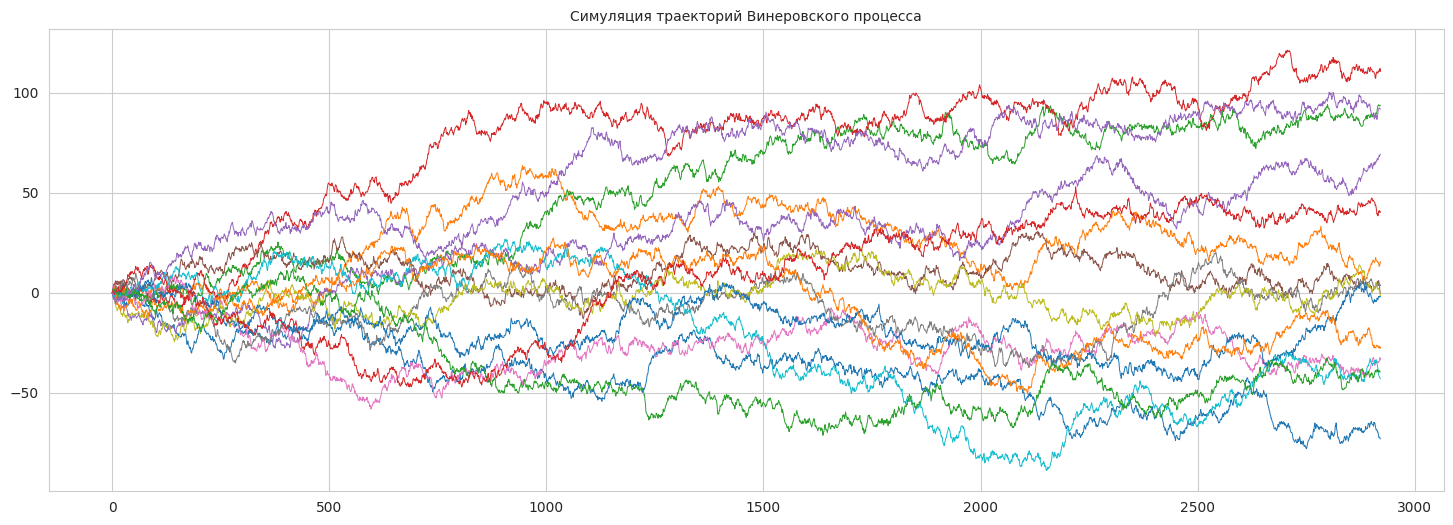

In [ ]:
fig, ax = plt.subplots(figsize=(18, 6))
ax.plot(t_array, wiener_traj.T, linewidth=0.7)
ax.set_title('Симуляция траекторий Винеровского процесса', fontsize=10)
plt.show()

### $1. \ dX_{t} = a \ dt + b \ dW_{t}$

$d X_t = a \ dt + b \ dW_t$\
$\Delta X_t = a \Delta t + b \Delta W_t$\
$X_t = X_{t-1} + a \Delta t + b \Delta W_t$

Если сделать следующие замены: $y=\Delta X_{t}, \ x = \Delta t$, то получим  $y = ax + b \varepsilon_t$ и найдем коэффициенты из линейной регрессии.

In [ ]:
def parametrs_estimation_1(r, dt):
    # замена
    y = np.diff(r)
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

In [ ]:
def process_1(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*dt[t-1] + b*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $ 2. \ dX_{t} = a \ X_{t} \ dt + b \ X_{t} \ dW_{t}$

$d X_t = a \ X_t \ dt + b \ X_t \ dW_t$

$\Delta X_{t} = a \ X_t \Delta t + b \ X_t \Delta W_t$

$\frac{\Delta X_{t}}{X_t} = a \Delta t + b \Delta W_t$

$X_t = X_{t-1} + a X_{t-1} \Delta t + b X_{t-1} \Delta W_t$

Сделаем следующие замены: $y=\frac{\Delta X_{t}}{X_t}, \ x = \Delta t$.\
Получим  $y = ax + b \varepsilon_t$. Найдем коэффициенты из линейной регрессии.

In [ ]:
def parametrs_estimation_2(r, dt):
    # замена
    r_t1 = r[:-1]
    y = np.diff(r) / r_t1
    X = np.concatenate([dt.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = linreg.coef_[0]
    b = np.std(y - y_pred)
    return {'a': a, 'b': b}

In [ ]:
def process_2(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b = param['a'], param['b']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*r_t1*dt[t-1] + b*r_t1*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $3. \ CIR$


Стохастическое дифференциальное уравнение для процесса Кокса-Ингерсолла-Росса выглядит следующим образом:

$ d r_{t} = a (b-r_{t})dt + c\sqrt{r_{t}} d W_{t} $

Для моделирования процесса воспользуемся дискретным уравнением:

$ r_{t} = r_{t-1} + a (b-r_{t-1}) \Delta t + c\sqrt{|{r_{t-1}}|} \Delta W_{t} $

Используется для симмуляции процентных ставок.

Подбор параметров осуществляется следующим образом.

$ \Delta r_{t} = a (b-r_t) \Delta t + c\sqrt{r_{t}} \Delta W_{t} $

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \frac{r_{t} \Delta t}{{\sqrt{r_{t}}}}  + c \Delta W_{t}$

$ \frac{\Delta r_{t}}{\sqrt{r_{t}}} = ab \frac{\Delta t}{{\sqrt{r_{t}}}} - a \sqrt{r_{t}} \Delta t  + c \Delta W_{t}$

Можно сделать следующие замены:

$y = \frac{\Delta r_{t}}{\sqrt{r_{t}}}$

$x_1 = \frac{\Delta t}{{\sqrt{r_{t}}}}$

$x_2 = \sqrt{r_{t}} \Delta t$

Тогда получим $y = abx_1 - ax_2 + c \varepsilon_t$ и найдем коэффициенты из линейной регрессии.


In [ ]:
def parametrs_estimation_CIR(r, dt):
    # замена
    sqrt_r_t1 = np.sqrt(r[:-1])
    y = np.diff(r) / sqrt_r_t1
    x_1 = dt / sqrt_r_t1
    x_2 = dt * sqrt_r_t1
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры: #p1 = ab, p2 = -a
    ab = linreg.coef_[0]
    a = -linreg.coef_[1]
    b = ab / a
    c = np.std(y - y_pred)
    if 2*a*b < c**2:
        #print('Ошибка в параметрах')
        print('Внимание: 2ab < c^2')
    return {'a': a, 'b': b, 'c': c}

In [ ]:
def process_CIR(param, r_0, dt, dWt):
    T = len(dt) + 1
    a, b, c = param['a'], param['b'], param['c']

    r_sim = [r_0]
    for t in range(1, T):
        r_t1 = r_sim[t-1]
        r_t = r_t1 + a*(b - r_t1)*dt[t-1] + c*np.sqrt(np.abs(r_t1))*dWt[t-1]
        r_sim.append(r_t)

    return np.asarray(r_sim)

### $4. \ FX$

В общем виде модель выглядит следующим образом:

$d(\ln X_t) = \frac{dX_t}{X_t} = k(\theta - \ln X_t)dt + \sigma_{FX}(t)dW_t$

Пусть $Y_t = \ln X_t$.

$dY_t = k(\theta - Y_t)dt + \sigma dW_t$

В дискретном случае:

$Y_t = Y_{t-1} + k(\theta - Y_{t-1})\Delta t + \sigma \Delta W_t$

$X_t = exp \{Y_t\}$

Подбор параметров:\
$\Delta Y_{t} = k(\theta - Y_t)\Delta t + \sigma \Delta W_{t} $

$\Delta Y_{t} = k \theta \Delta t - k Y_t \Delta t + \sigma \Delta W_{t} $

Тогда заменяем $y = \Delta Y_{t}, \ x_1 = \Delta t, \ x_2 = Y_t \Delta t$.

In [ ]:
def parametrs_estimation_FX(r, dt):
    # замена
    y = np.diff(r)
    x_1 = dt
    x_2 = dt * r[:-1]
    X = np.concatenate([x_1.reshape(-1, 1), x_2.reshape(-1, 1)], axis=1)
    # lin reg
    linreg = LinearRegression(fit_intercept=False)
    linreg.fit(X, y)
    y_pred = linreg.predict(X)
    # параметры
    a = -linreg.coef_[1]
    b = linreg.coef_[0] / a
    c = np.std(y - y_pred)
    return {'k': a, 'theta': b, 'sigma': c}

In [ ]:
def process_FX(param, r_0, dt, dWt):
    T = len(dt) + 1
    k, th, sigma = param['k'], param['theta'], param['sigma']

    y_sim = [r_0]
    for t in range(1, T):
        y_t1 = y_sim[t-1]
        y_t = y_t1 + k*(th - y_t1)*dt[t-1] + sigma*dWt[t-1]
        y_sim.append(y_t)

    return np.exp(y_sim)

### Общий модуль

In [ ]:
class Stoch_Models:
    def __init__(self, factor_name, factor_value, t_array, N_traj=10, models=None):
        self.name = factor_name
        self.val = factor_value.values
        self.val_t0 = factor_value.values[0]
        self.t = t_array
        self.dt = np.diff(t_array)
        self.N_traj = N_traj

        # модели
        if models is None:
            self.models = ['m1', 'm2', 'm3', 'm4']
        else:
            self.models = models

        self.models_info = {
            'm1': '1',
            'm2': '2',
            'm3': 'CIR',
            'm4': 'FX'
        }

        # параметры
        self.parametrs_func = {
            'm1': parametrs_estimation_1,
            'm2': parametrs_estimation_2,
            'm3': parametrs_estimation_CIR,
            'm4': parametrs_estimation_FX
        }
        self.paramters = {}

        # симуляции
        self.simulations_func = {
            'm1': process_1,
            'm2': process_2,
            'm3': process_CIR,
            'm4': process_FX
        }
        self.simulations = {}

        self.colors = {
            'm1': 'goldenrod',
            'm2': 'seagreen',
            'm3': 'steelblue',
            'm4': 'indianred',
            'factor': 'black'
        }

    def Wiener_simulation(self, w0=0):
        wiener_traj = Wiener_process(w0, self.dt, self.N_traj)
        dW_N = np.diff(wiener_traj, axis=1)
        return dW_N

    def find_parametrs(self):
        for m in self.models:
            self.paramters[m] = self.parametrs_func[m](self.val, self.dt)

    def make_simulations(self):
        dWts = self.Wiener_simulation()
        self.find_parametrs()

        for m in self.models:
            r_traj = []
            for dWt in dWts:
                r_tr = self.simulations_func[m](param=self.paramters[m], r_0=self.val_t0, dt=self.dt, dWt=dWt)
                r_traj.append(np.array(r_tr))
            self.simulations[m] = np.array(r_traj)

    def print_simulations(self, fig_size = (20, 8)):
        self.make_simulations()

        fig, axs = plt.subplots(1, 1, figsize=fig_size)
        for m in self.models:
            axs.plot(self.simulations[m].T, color=self.colors[m], linewidth=0.5)
            axs.plot(np.mean(self.simulations[m], axis=0), color=self.colors[m], linewidth=2, label=self.models_info[m])
        axs.plot(self.val, color=self.colors['factor'], linewidth=1.5, label='factor')
        axs.legend()
        axs.set_title(self.name)
        plt.show()

    #def future_simulation(self, n_steps=1, models=None):
        #

In [ ]:
#rub_rate_dt = np.array((dates[1:].reset_index(drop=True) - dates[:-1].reset_index(drop=True)).dt.days)

In [ ]:
f_col = 'Курс доллара'

t0 = 0
N = data.shape[0]
t_step = 1
t_array = np.round(np.arange(t0, N, t_step))

In [ ]:
sm = Stoch_Models(factor_name=f_col, factor_value=data[f_col], t_array=t_array, models=['m1', 'm2', 'm3'])

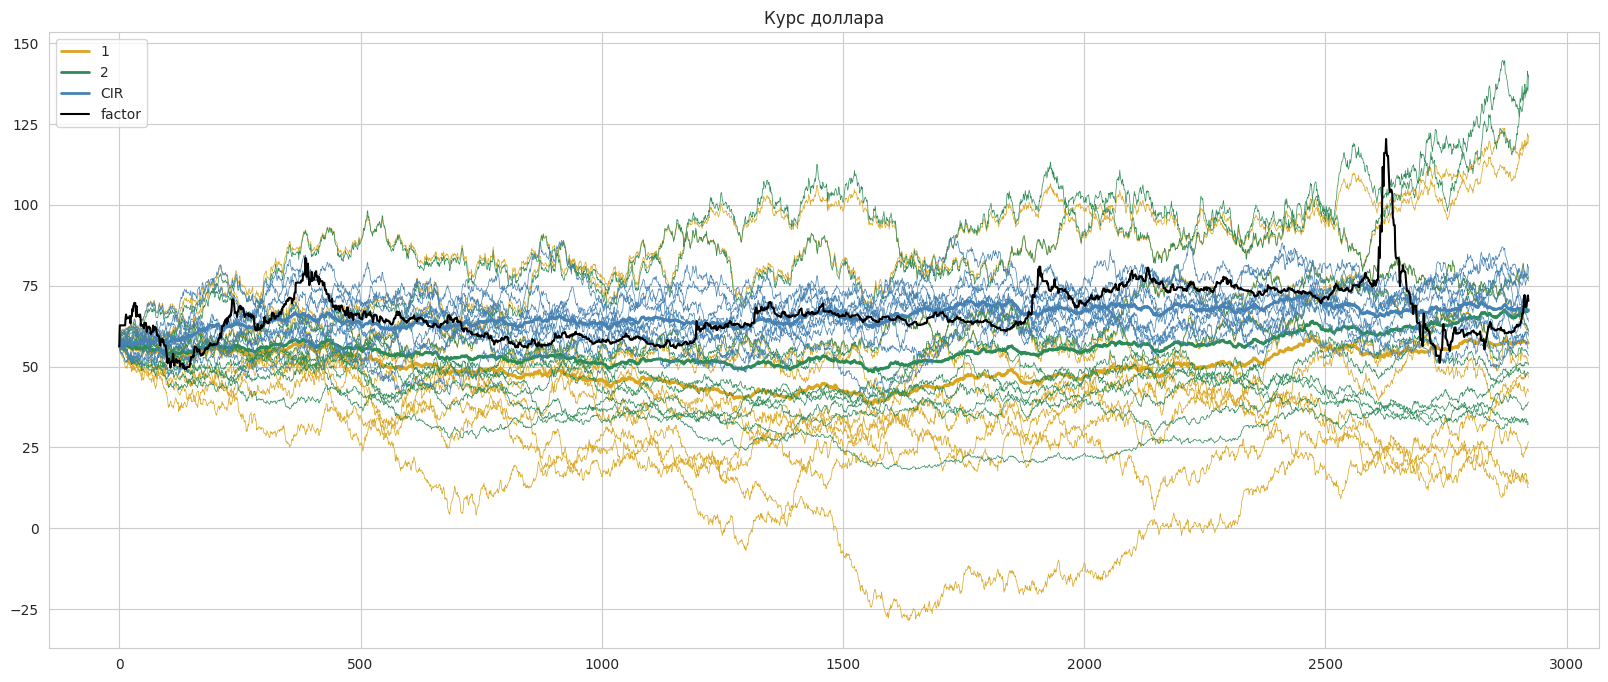

In [ ]:
sm.print_simulations()

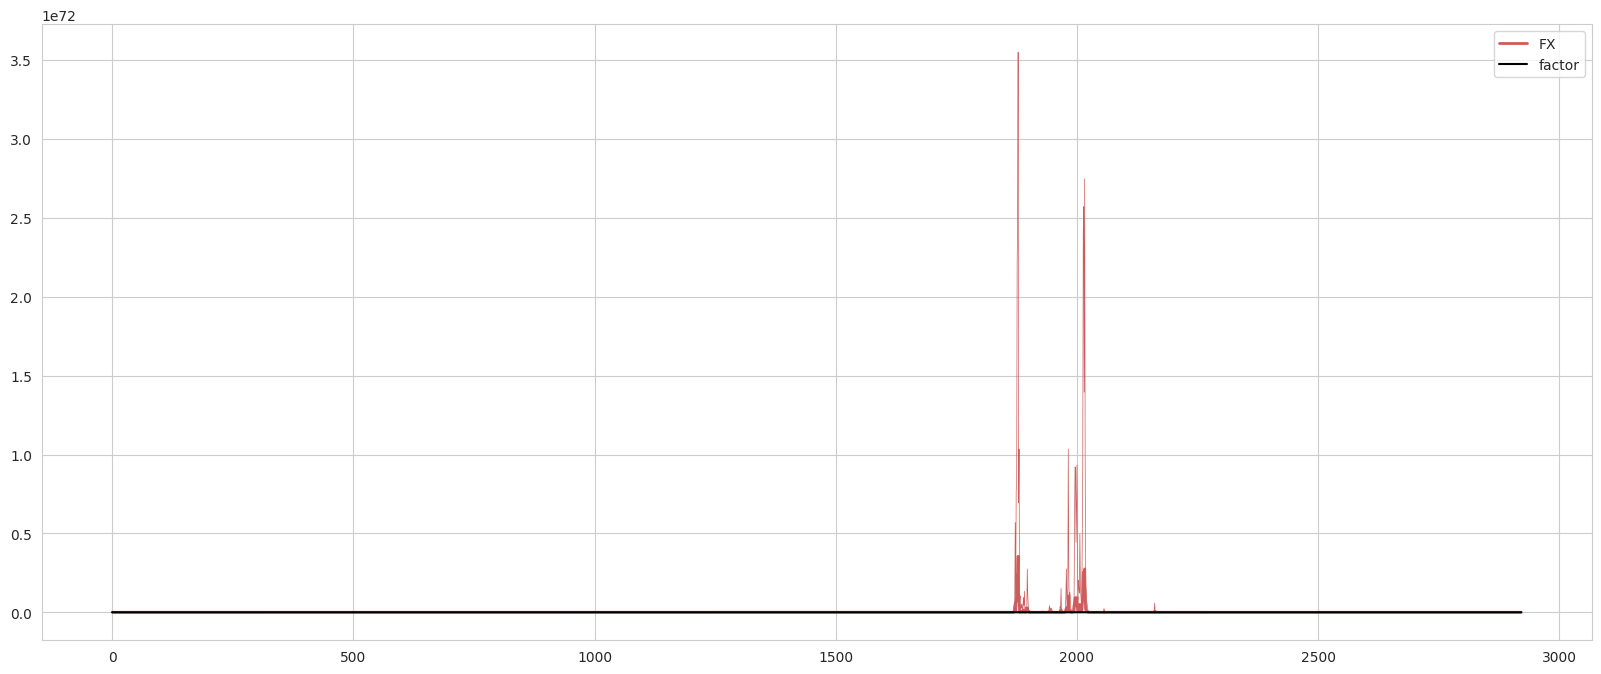

In [ ]:
sm = Stoch_Models(factor_name=f_col, factor_value=data[f_col], t_array=t_array, models=['m4'])
sm.print_simulations(fig_size=(20,8))